1. First we define a class called ODEModel which defines an object which is our neural network.
2. Then we define a function f(x,y) which is the rhs of differential equation's dy/dx
3. Then we define the initial condition such that we require grad for x=(x_0=0)
4. Then we define the loss function which takes the range/grid of x and the model/object i.e. neural network.

Epoch 0: Loss = 3.0719187259674072
Epoch 100: Loss = 0.5689175724983215
Epoch 200: Loss = 0.03633517771959305
Epoch 300: Loss = 0.013330698944628239
Epoch 400: Loss = 0.004346503876149654
Epoch 500: Loss = 0.0020719587337225676
Epoch 600: Loss = 0.001566797262057662
Epoch 700: Loss = 0.0014138615224510431
Epoch 800: Loss = 0.0013398525770753622
Epoch 900: Loss = 0.0012853456428274512


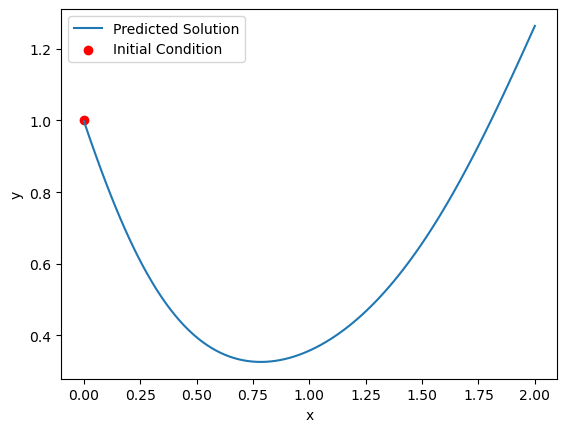

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.hidden = nn.Linear(1, 10)  # One hidden layer with 10 neurons
        self.output = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.hidden(x))  # Activation function
        return self.output(x)

# Define the differential equation function
def f(x, y):
    # Example: dy/dx = -2y + x^2
    return -2 * y + x**2

# Initial condition
x0 = torch.tensor([[0.0]], requires_grad=True)  # Initial x
y0 = torch.tensor([[1.0]])  # Initial condition for y(0) = 1

# Loss function with initial condition
def loss_function(x, model):
    x.requires_grad_(True)  # Enable gradient computation for x
    y_pred = model(x)
    dy_dx = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    diff_eq = dy_dx - f(x, y_pred)
    
    # Boundary/initial condition loss
    y0_pred = model(x0)  # Predicted y at initial point x0
    initial_condition_loss = torch.mean((y0_pred - y0)**2)  # Penalize deviation from initial condition

    # Total loss: differential equation loss + initial condition loss
    return torch.mean(diff_eq**2) + initial_condition_loss

# Define the model, optimizer, and initial condition
model = ODEModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):  # Number of epochs
    x = torch.linspace(0, 2, 100).unsqueeze(1)  # Define input values (e.g., 0 to 2)

    # Zero gradients, compute loss, backpropagate, and update weights
    optimizer.zero_grad()
    loss = loss_function(x, model)  # Pass the model directly to loss_function
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

# Testing the trained model
x_test = torch.linspace(0, 2, 100).unsqueeze(1)
y_test = model(x_test).detach().numpy()

# Visualize the solution
import matplotlib.pyplot as plt
plt.plot(x_test.numpy(), y_test, label="Predicted Solution")
plt.scatter(x0.detach().numpy(), y0.detach().numpy(), color="red", label="Initial Condition")  # Mark initial condition
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


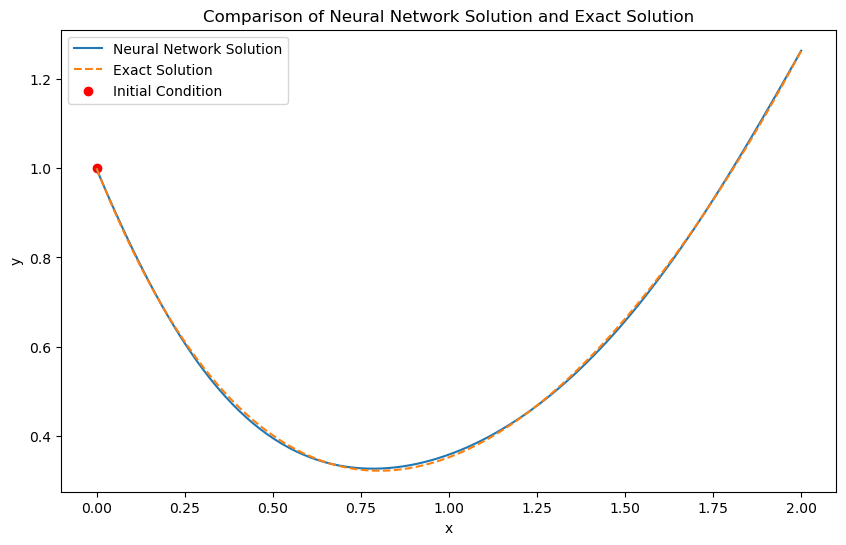

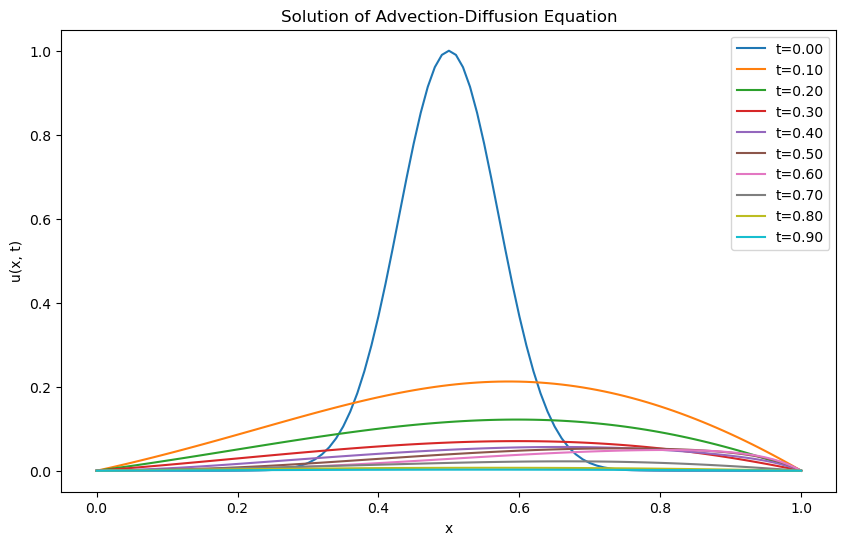

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
x_min = 0.0
x_max = 1.0
t_min = 0.0
t_max = 1.0

Nx = 101          # Number of spatial grid points
Nt = 1000         # Number of time steps

x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]
dt = (t_max - t_min) / (Nt - 1)
t = np.linspace(t_min, t_max, Nt)

# Stability parameters
c = 1.0           # Advection speed
lambda_max = 1.0  # Maximum value of λ(t)

# Check CFL conditions
CFL_advection = c * dt / dx
CFL_diffusion = lambda_max * dt / dx**2
if CFL_advection > 1.0 or CFL_diffusion > 0.5:
    print("Warning: CFL condition not satisfied. Adjust dt or dx for stability.")

# Initialize solution array
u = np.zeros((Nt, Nx))

# Initial condition: Gaussian pulse centered at x=0.5
u[0, :] = np.exp(-100 * (x - 0.5)**2)

# Boundary conditions
u[:, 0] = 0.0     # u(0, t) = 0
u[:, -1] = 0.0    # u(1, t) = 0

# Time-stepping
for n in range(0, Nt - 1):
    # Determine λ(t) based on current time t[n]
    if t[n] >= 0 and t[n] < 1/3:
        lambda_n = 0.5
    elif t[n] >= 1/3 and t[n] < 2/3:
        lambda_n = 0.05
    else:
        lambda_n = 1.0

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Coefficients for the tridiagonal matrix
    lower = -a * np.ones(Nx - 3)
    main = (1 + 2 * a) * np.ones(Nx - 2)
    upper = -a * np.ones(Nx - 3)

    # Build RHS of the system
    RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

    # Adjust RHS for boundary conditions (Dirichlet conditions, u[0]=u[-1]=0)
    # Since u[0] and u[-1] are zero, no need to adjust RHS

    # Solve tridiagonal system using Thomas algorithm
    # Forward sweep
    for j in range(1, Nx - 2):
        w = lower[j - 1] / main[j - 1]
        main[j] = main[j] - w * upper[j - 1]
        RHS[j] = RHS[j] - w * RHS[j - 1]

    # Back substitution
    u_new = np.zeros(Nx - 2)
    u_new[-1] = RHS[-1] / main[-1]
    for j in range(Nx - 4, -1, -1):
        u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

    # Update solution
    u[n + 1, 1:-1] = u_new

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(0, Nt, Nt // 10):
    plt.plot(x, u[i, :], label=f't={t[i]:.2f}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Solution of Advection-Diffusion Equation')
plt.legend()
plt.show()


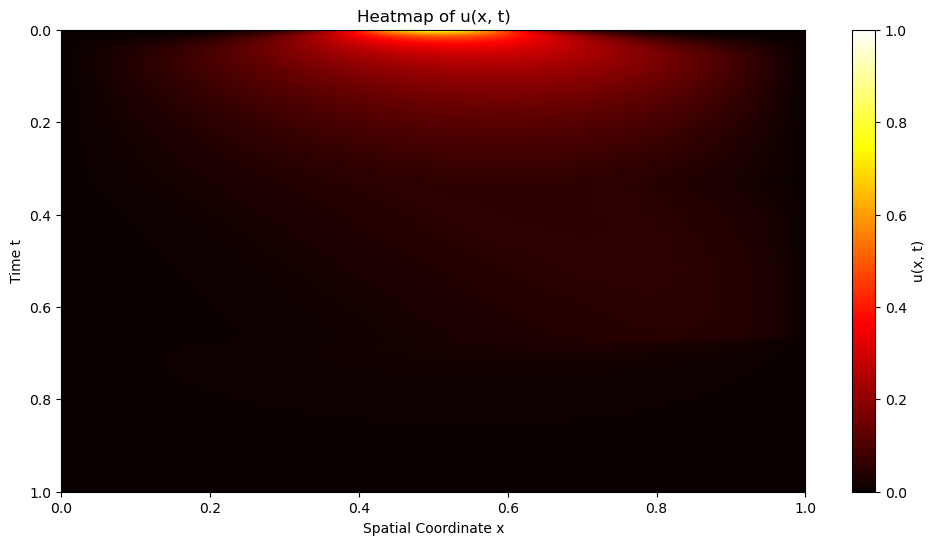

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
x_min = 0.0
x_max = 1.0
t_min = 0.0
t_max = 1.0

Nx = 101          # Number of spatial grid points
Nt = 1000         # Number of time steps

x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]
dt = (t_max - t_min) / (Nt - 1)
t = np.linspace(t_min, t_max, Nt)

# Stability parameters
c = 1.0           # Advection speed
lambda_max = 1.0  # Maximum value of λ(t)

# Check CFL conditions
CFL_advection = c * dt / dx
CFL_diffusion = lambda_max * dt / dx**2
if CFL_advection > 1.0 or CFL_diffusion > 0.5:
    print("Warning: CFL condition not satisfied. Adjust dt or dx for stability.")

# Initialize solution array
u = np.zeros((Nt, Nx))

# Initial condition: Gaussian pulse centered at x=0.5
u[0, :] = np.exp(-100 * (x - 0.5)**2)

# Boundary conditions
u[:, 0] = 0.0     # u(0, t) = 0
u[:, -1] = 0.0    # u(1, t) = 0

# Time-stepping
for n in range(0, Nt - 1):
    # Determine λ(t) based on current time t[n]
    if t[n] >= 0 and t[n] < 1/3:
        lambda_n = 0.5
    elif t[n] >= 1/3 and t[n] < 2/3:
        lambda_n = 0.05
    else:
        lambda_n = 1.0

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Coefficients for the tridiagonal matrix
    lower = -a * np.ones(Nx - 3)
    main = (1 + 2 * a) * np.ones(Nx - 2)
    upper = -a * np.ones(Nx - 3)

    # Build RHS of the system
    RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

    # Solve tridiagonal system using Thomas algorithm
    # Forward sweep
    for j in range(1, Nx - 2):
        w = lower[j - 1] / main[j - 1]
        main[j] = main[j] - w * upper[j - 1]
        RHS[j] = RHS[j] - w * RHS[j - 1]

    # Back substitution
    u_new = np.zeros(Nx - 2)
    u_new[-1] = RHS[-1] / main[-1]
    for j in range(Nx - 4, -1, -1):
        u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

    # Update solution
    u[n + 1, 1:-1] = u_new

# Create a color heatmap plot
plt.figure(figsize=(12, 6))

# Use imshow for the heatmap
extent = [x_min, x_max, t_max, t_min]  # t_max to t_min to have t increasing upwards
plt.imshow(u, extent=extent, aspect='auto', cmap='hot')

plt.colorbar(label='u(x, t)')
plt.xlabel('Spatial Coordinate x')
plt.ylabel('Time t')
plt.title('Heatmap of u(x, t)')
plt.show()


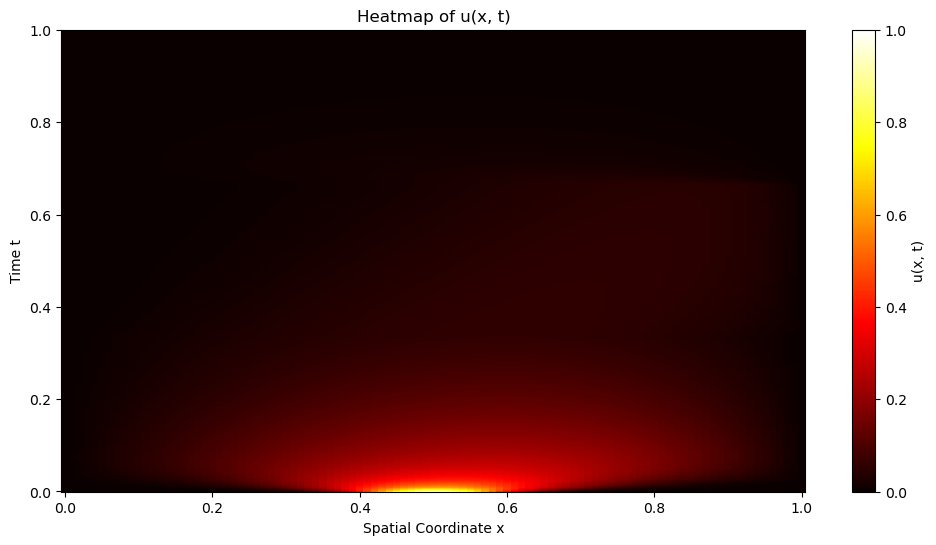

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define spatial parameters
x_min = 0.0
x_max = 1.0
Nx = 101          # Number of spatial grid points
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Define time intervals
t0 = 0.0
t1 = 1.0 / 3.0
t2 = 2.0 / 3.0
t3 = 1.0

# Total number of time steps
Nt_total = 1000

# Time step size
dt = (t3 - t0) / (Nt_total - 1)

# Number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = Nt_total - Nt1 - Nt2 + 2  # Adjusted for overlap at boundaries

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)

# Combine time vectors for plotting, removing duplicate points at overlaps
t = np.concatenate((t_interval1[:-1], t_interval2[:-1], t_interval3))

# Initialize solution array with adjusted size
Nt_combined = Nt1 + Nt2 + Nt3 - 2  # Subtract overlaps
u_total = np.zeros((Nt_combined, Nx))

# Initial condition: Gaussian pulse centered at x=0.5
u0 = np.exp(-100 * (x - 0.5)**2)
u_total[0, :] = u0

# Boundary conditions
u_total[:, 0] = 0.0     # u(0, t) = 0
u_total[:, -1] = 0.0    # u(1, t) = 0

# Advection speed
c = 1.0

# Function to solve the PDE over a given interval
def solve_interval(u_initial, t_start, t_end, Nt_interval, lambda_n):
    dt = (t_end - t_start) / (Nt_interval - 1)
    CFL_advection = c * dt / dx
    CFL_diffusion = lambda_n * dt / dx**2
    if CFL_advection > 1.0 or CFL_diffusion > 0.5:
        print(f"Warning: CFL condition not satisfied in interval [{t_start}, {t_end}]. Adjust dt or dx for stability.")

    u = np.zeros((Nt_interval, Nx))
    u[0, :] = u_initial
    u[:, 0] = 0.0     # Boundary condition at x=0
    u[:, -1] = 0.0    # Boundary condition at x=1

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Time-stepping
    for n in range(0, Nt_interval - 1):
        # Coefficients for the tridiagonal matrix
        lower = -a * np.ones(Nx - 3)
        main = (1 + 2 * a) * np.ones(Nx - 2)
        upper = -a * np.ones(Nx - 3)

        # Build RHS of the system
        RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

        # Forward sweep (Thomas algorithm)
        for j in range(1, Nx - 2):
            w = lower[j - 1] / main[j - 1]
            main[j] = main[j] - w * upper[j - 1]
            RHS[j] = RHS[j] - w * RHS[j - 1]

        # Back substitution
        u_new = np.zeros(Nx - 2)
        u_new[-1] = RHS[-1] / main[-1]
        for j in range(Nx - 4, -1, -1):
            u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

        # Update solution
        u[n + 1, 1:-1] = u_new

    return u

# Solve over the first interval [t0, t1]
lambda1 = 0.5
u_interval1 = solve_interval(u_total[0, :], t0, t1, Nt1, lambda1)
u_total[0:Nt1, :] = u_interval1

# Solve over the second interval [t1, t2]
lambda2 = 0.05
u_initial2 = u_interval1[-1, :]
u_interval2 = solve_interval(u_initial2, t1, t2, Nt2, lambda2)
u_total[Nt1 - 1:Nt1 + Nt2 - 1, :] = u_interval2

# Solve over the third interval [t2, t3]
lambda3 = 1.0
u_initial3 = u_interval2[-1, :]
u_interval3 = solve_interval(u_initial3, t2, t3, Nt3, lambda3)
u_total[Nt1 + Nt2 - 2:, :] = u_interval3

# Create a color heatmap plot
plt.figure(figsize=(12, 6))

# Prepare the data for plotting
X, T = np.meshgrid(x, t)
plt.pcolormesh(X, T, u_total, shading='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('Spatial Coordinate x')
plt.ylabel('Time t')
plt.title('Heatmap of u(x, t)')
plt.show()


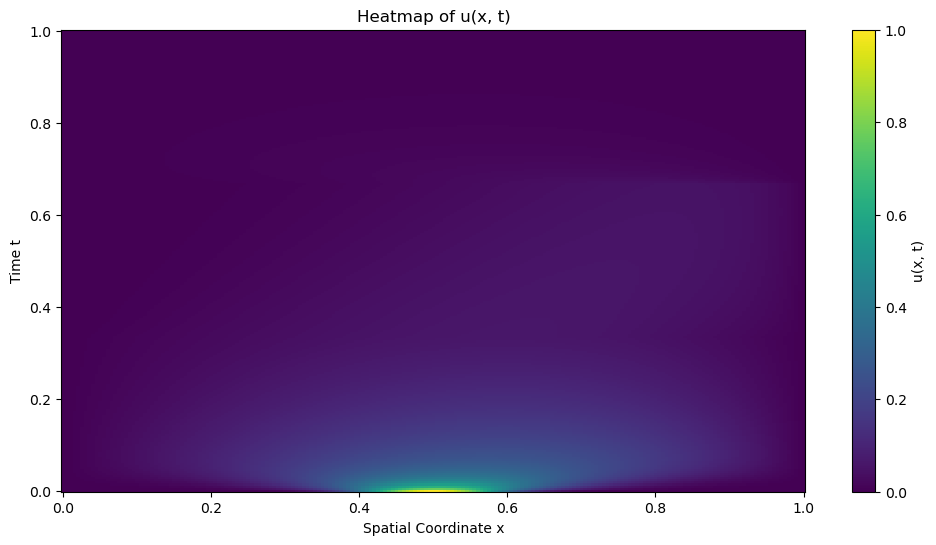

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define spatial parameters
x_min = 0.0
x_max = 1.0
Nx = 201          # Increase spatial resolution for better accuracy
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Advection speed
c = 1.0

# Adjust dt based on CFL condition for advection
dt_max = dx / c
dt = dt_max * 0.9  # Use 90% of the maximum allowable dt for stability

# Define time intervals
t0 = 0.0
t1 = 1.0 / 3.0
t2 = 2.0 / 3.0
t3 = 1.0

# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1

# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)

# Combine time vectors for plotting, removing duplicate points at overlaps
t = np.concatenate((t_interval1[:-1], t_interval2[:-1], t_interval3))

# Initialize solution array with adjusted size
Nt_combined = Nt1 + Nt2 + Nt3 - 2  # Subtract overlaps
u_total = np.zeros((Nt_combined, Nx))

# Initial condition: Gaussian pulse centered at x=0.5
u0 = np.exp(-100 * (x - 0.5)**2)
u_total[0, :] = u0

# Boundary conditions
u_total[:, 0] = 0.0     # u(0, t) = 0
u_total[:, -1] = 0.0    # u(1, t) = 0

# Function to solve the PDE over a given interval
def solve_interval(u_initial, t_start, t_end, Nt_interval, lambda_n, dt_interval):
    dt = dt_interval
    CFL_advection = c * dt / dx
    if CFL_advection > 1.0:
        print(f"Warning: CFL condition for advection not satisfied in interval [{t_start}, {t_end}]. Adjust dt or dx for stability.")

    u = np.zeros((Nt_interval, Nx))
    u[0, :] = u_initial
    u[:, 0] = 0.0     # Boundary condition at x=0
    u[:, -1] = 0.0    # Boundary condition at x=1

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Time-stepping
    for n in range(0, Nt_interval - 1):
        # Coefficients for the tridiagonal matrix
        lower = -a * np.ones(Nx - 3)
        main = (1 + 2 * a) * np.ones(Nx - 2)
        upper = -a * np.ones(Nx - 3)

        # Build RHS of the system
        RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

        # Forward sweep (Thomas algorithm)
        for j in range(1, Nx - 2):
            w = lower[j - 1] / main[j - 1]
            main[j] = main[j] - w * upper[j - 1]
            RHS[j] = RHS[j] - w * RHS[j - 1]

        # Back substitution
        u_new = np.zeros(Nx - 2)
        u_new[-1] = RHS[-1] / main[-1]
        for j in range(Nx - 4, -1, -1):
            u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

        # Update solution
        u[n + 1, 1:-1] = u_new

    return u

# Solve over the first interval [t0, t1]
lambda1 = 0.5
u_interval1 = solve_interval(u_total[0, :], t0, t1, Nt1, lambda1, dt1)
u_total[0:Nt1, :] = u_interval1

# Solve over the second interval [t1, t2]
lambda2 = 0.05
u_initial2 = u_interval1[-1, :]
u_interval2 = solve_interval(u_initial2, t1, t2, Nt2, lambda2, dt2)
u_total[Nt1 - 1:Nt1 + Nt2 - 1, :] = u_interval2

# Solve over the third interval [t2, t3]
lambda3 = 1.0
u_initial3 = u_interval2[-1, :]
u_interval3 = solve_interval(u_initial3, t2, t3, Nt3, lambda3, dt3)
u_total[Nt1 + Nt2 - 2:, :] = u_interval3

# Create a color heatmap plot
plt.figure(figsize=(12, 6))

# Prepare the data for plotting
X, T = np.meshgrid(x, t)
plt.pcolormesh(X, T, u_total, shading='auto')
plt.colorbar(label='u(x, t)')
plt.xlabel('Spatial Coordinate x')
plt.ylabel('Time t')
plt.title('Heatmap of u(x, t)')
plt.show()


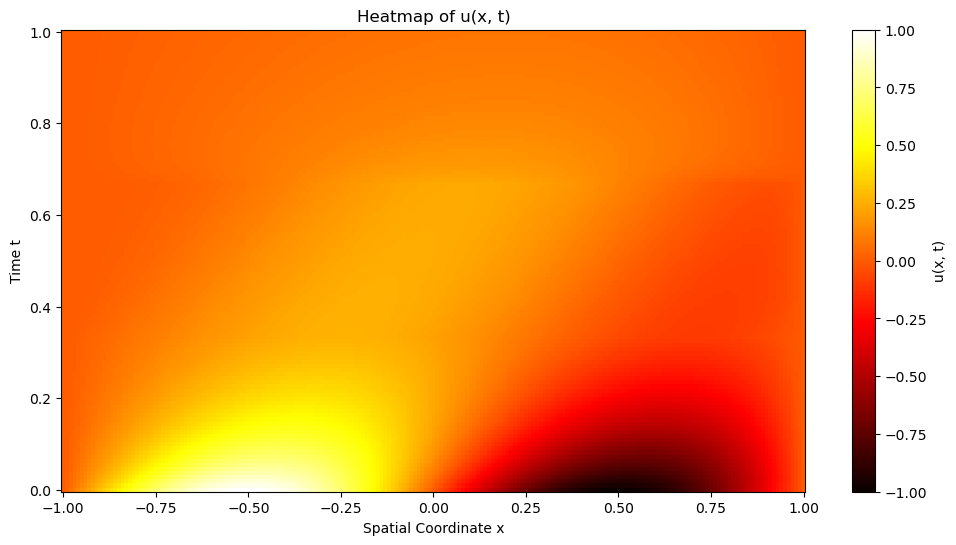

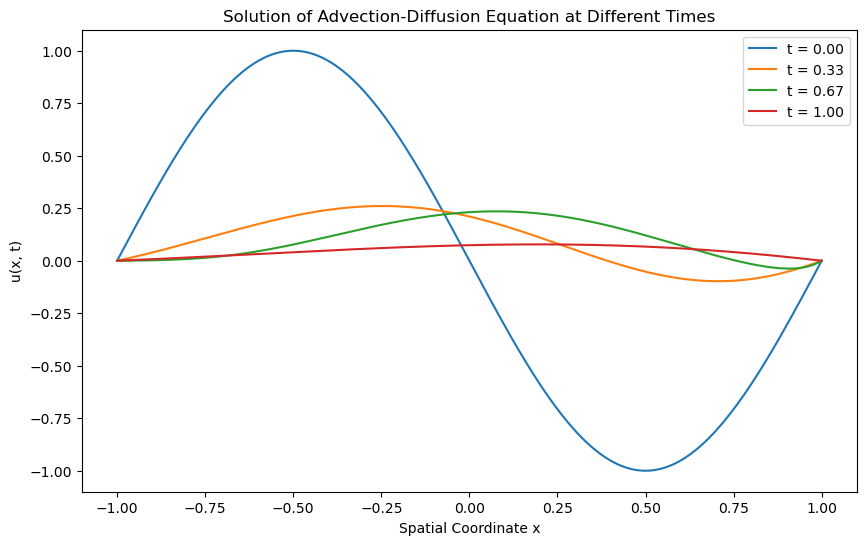

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define spatial parameters
x_min = -1.0
x_max = 1.0
Nx = 201          # Spatial resolution
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Advection speed
c = 1.0

# Adjust dt based on CFL condition for advection
dt_max = dx / c
dt = dt_max * 0.9  # Use 90% of the maximum allowable dt for stability

# Define time intervals
t0 = 0.0
t1 = 1.0 / 3.0
t2 = 2.0 / 3.0
t3 = 1.0

# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1

# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)

# Combine time vectors for plotting, removing duplicate points at overlaps
t = np.concatenate((t_interval1[:-1], t_interval2[:-1], t_interval3))

# Initialize solution array with adjusted size
Nt_combined = Nt1 + Nt2 + Nt3 - 2  # Subtract overlaps
u_total = np.zeros((Nt_combined, Nx))

# New initial condition: u(t=0, x) = -sin(π x)
u0 = -np.sin(np.pi * x)
u_total[0, :] = u0

# Boundary conditions (already satisfied by the initial condition)
u_total[:, 0] = 0.0     # u(0, t) = 0
u_total[:, -1] = 0.0    # u(1, t) = 0

# Function to solve the PDE over a given interval
def solve_interval(u_initial, t_start, t_end, Nt_interval, lambda_n, dt_interval):
    dt = dt_interval
    CFL_advection = c * dt / dx
    if CFL_advection > 1.0:
        print(f"Warning: CFL condition for advection not satisfied in interval [{t_start}, {t_end}]. Adjust dt or dx for stability.")

    u = np.zeros((Nt_interval, Nx))
    u[0, :] = u_initial
    u[:, 0] = 0.0     # Boundary condition at x=0
    u[:, -1] = 0.0    # Boundary condition at x=1

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Time-stepping
    for n in range(0, Nt_interval - 1):
        # Coefficients for the tridiagonal matrix
        lower = -a * np.ones(Nx - 3)
        main = (1 + 2 * a) * np.ones(Nx - 2)
        upper = -a * np.ones(Nx - 3)

        # Build RHS of the system
        RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

        # Forward sweep (Thomas algorithm)
        for j in range(1, Nx - 2):
            w = lower[j - 1] / main[j - 1]
            main[j] = main[j] - w * upper[j - 1]
            RHS[j] = RHS[j] - w * RHS[j - 1]

        # Back substitution
        u_new = np.zeros(Nx - 2)
        u_new[-1] = RHS[-1] / main[-1]
        for j in range(Nx - 4, -1, -1):
            u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

        # Update solution
        u[n + 1, 1:-1] = u_new

    return u

# Solve over the first interval [t0, t1]
lambda1 = 0.5
#lambda1 = 0
u_interval1 = solve_interval(u_total[0, :], t0, t1, Nt1, lambda1, dt1)
u_total[0:Nt1, :] = u_interval1

# Solve over the second interval [t1, t2]
lambda2 = 0.05
#lambda2 = 0
u_initial2 = u_interval1[-1, :]
u_interval2 = solve_interval(u_initial2, t1, t2, Nt2, lambda2, dt2)
u_total[Nt1 - 1:Nt1 + Nt2 - 1, :] = u_interval2

# Solve over the third interval [t2, t3]
lambda3 = 1.0
#lambda3 = 0
u_initial3 = u_interval2[-1, :]
u_interval3 = solve_interval(u_initial3, t2, t3, Nt3, lambda3, dt3)
u_total[Nt1 + Nt2 - 2:, :] = u_interval3

# Create a color heatmap plot
plt.figure(figsize=(12, 6))

# Prepare the data for plotting
X, T = np.meshgrid(x, t)
plt.pcolormesh(X, T, u_total, shading='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('Spatial Coordinate x')
plt.ylabel('Time t')
plt.title('Heatmap of u(x, t)')
plt.show()

# Plot the solution at different time steps
plt.figure(figsize=(10, 6))
time_indices = [0, Nt1 - 1, Nt1 + Nt2 - 2, Nt_combined - 1]
for idx in time_indices:
    plt.plot(x, u_total[idx, :], label=f't = {t[idx]:.2f}')
plt.xlabel('Spatial Coordinate x')
plt.ylabel('u(x, t)')
plt.title('Solution of Advection-Diffusion Equation at Different Times')
plt.legend()
plt.show()


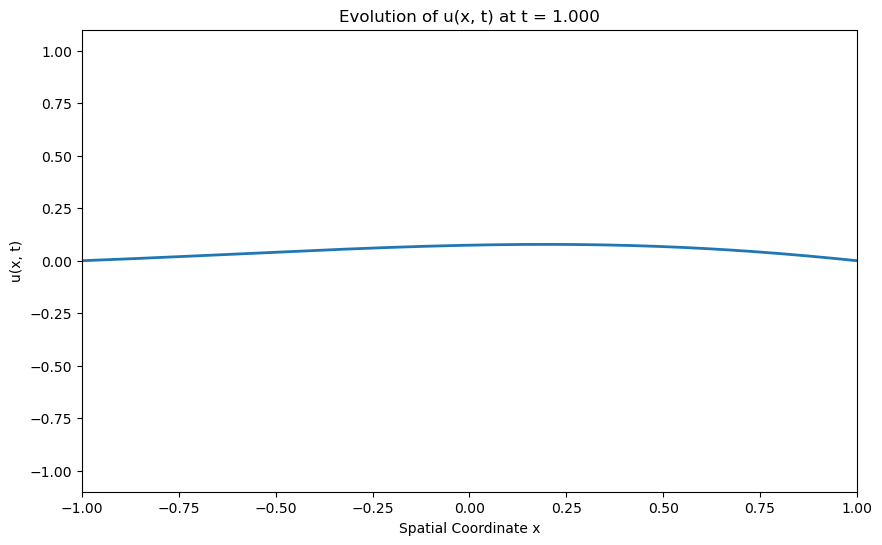

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Ensure that animations display properly in the notebook
%matplotlib inline

# Define spatial parameters
x_min = -1.0
x_max = 1.0
Nx = 201          # Spatial resolution
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Advection speed
c = 1.0

# Adjust dt based on CFL condition for advection
dt_max = dx / c
dt = dt_max * 0.9  # Use 90% of the maximum allowable dt for stability

# Define time intervals
t0 = 0.0
t1 = 1.0 / 3.0
t2 = 2.0 / 3.0
t3 = 1.0

# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1

# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)

# Combine time vectors for plotting, removing duplicate points at overlaps
t = np.concatenate((t_interval1[:-1], t_interval2[:-1], t_interval3))

# Initialize solution array with adjusted size
Nt_combined = Nt1 + Nt2 + Nt3 - 2  # Subtract overlaps
u_total = np.zeros((Nt_combined, Nx))

# New initial condition: u(t=0, x) = -sin(π x)
u0 = -np.sin(np.pi * x)
u_total[0, :] = u0

# Boundary conditions (already satisfied by the initial condition)
u_total[:, 0] = 0.0     # u(-1, t) = 0
u_total[:, -1] = 0.0    # u(1, t) = 0

# Function to solve the PDE over a given interval
def solve_interval(u_initial, t_start, t_end, Nt_interval, lambda_n, dt_interval):
    dt = dt_interval
    CFL_advection = c * dt / dx
    if CFL_advection > 1.0:
        print(f"Warning: CFL condition for advection not satisfied in interval [{t_start}, {t_end}]. Adjust dt or dx for stability.")

    u = np.zeros((Nt_interval, Nx))
    u[0, :] = u_initial
    u[:, 0] = 0.0     # Boundary condition at x=0
    u[:, -1] = 0.0    # Boundary condition at x=1

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Time-stepping
    for n in range(0, Nt_interval - 1):
        # Coefficients for the tridiagonal matrix
        lower = -a * np.ones(Nx - 3)
        main = (1 + 2 * a) * np.ones(Nx - 2)
        upper = -a * np.ones(Nx - 3)

        # Build RHS of the system
        RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

        # Forward sweep (Thomas algorithm)
        for j in range(1, Nx - 2):
            w = lower[j - 1] / main[j - 1]
            main[j] = main[j] - w * upper[j - 1]
            RHS[j] = RHS[j] - w * RHS[j - 1]

        # Back substitution
        u_new = np.zeros(Nx - 2)
        u_new[-1] = RHS[-1] / main[-1]
        for j in range(Nx - 4, -1, -1):
            u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

        # Update solution
        u[n + 1, 1:-1] = u_new

    return u

# Solve over the first interval [t0, t1]
lambda1 = 0.5
u_interval1 = solve_interval(u_total[0, :], t0, t1, Nt1, lambda1, dt1)
u_total[0:Nt1, :] = u_interval1

# Solve over the second interval [t1, t2]
lambda2 = 0.05
u_initial2 = u_interval1[-1, :] #Initial condition for second interval is the final time configuration of the first interval solution
u_interval2 = solve_interval(u_initial2, t1, t2, Nt2, lambda2, dt2)
u_total[Nt1 - 1:Nt1 + Nt2 - 1, :] = u_interval2

# Solve over the third interval [t2, t3]
lambda3 = 1.0
u_initial3 = u_interval2[-1, :]
u_interval3 = solve_interval(u_initial3, t2, t3, Nt3, lambda3, dt3)
u_total[Nt1 + Nt2 - 2:, :] = u_interval3

# Prepare the data for animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('Spatial Coordinate x')
ax.set_ylabel('u(x, t)')
ax.set_title('Evolution of u(x, t) Over Time')

# Initialize function for animation
def init():
    line.set_data([], [])
    return line,

# Animation function
def animate(i):
    y = u_total[i, :]
    line.set_data(x, y)
    ax.set_title(f'Evolution of u(x, t) at t = {t[i]:.3f}')
    return line,

# Create the animation
frame_interval = 1  # Adjust this to control the speed of the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt_combined, interval=frame_interval, blit=True)

# Display the animation in the notebook
HTML(anim.to_jshtml())

In [45]:
anim.save("advection_diffusion_evolution.gif", writer="pillow", fps=30)

In [36]:
x

array([-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
       -0.91, -0.9 , -0.89, -0.88, -0.87, -0.86, -0.85, -0.84, -0.83,
       -0.82, -0.81, -0.8 , -0.79, -0.78, -0.77, -0.76, -0.75, -0.74,
       -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.67, -0.66, -0.65,
       -0.64, -0.63, -0.62, -0.61, -0.6 , -0.59, -0.58, -0.57, -0.56,
       -0.55, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47,
       -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38,
       -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
        0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,
        0.17,  0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,
        0.26,  0.27,

In [38]:
Nt1

38

In [40]:
Nt2

38

In [42]:
Nt3

38

In [44]:
Nt1+Nt2+Nt3

114

In [46]:
t

array([0.        , 0.00900901, 0.01801802, 0.02702703, 0.03603604,
       0.04504505, 0.05405405, 0.06306306, 0.07207207, 0.08108108,
       0.09009009, 0.0990991 , 0.10810811, 0.11711712, 0.12612613,
       0.13513514, 0.14414414, 0.15315315, 0.16216216, 0.17117117,
       0.18018018, 0.18918919, 0.1981982 , 0.20720721, 0.21621622,
       0.22522523, 0.23423423, 0.24324324, 0.25225225, 0.26126126,
       0.27027027, 0.27927928, 0.28828829, 0.2972973 , 0.30630631,
       0.31531532, 0.32432432, 0.33333333, 0.34234234, 0.35135135,
       0.36036036, 0.36936937, 0.37837838, 0.38738739, 0.3963964 ,
       0.40540541, 0.41441441, 0.42342342, 0.43243243, 0.44144144,
       0.45045045, 0.45945946, 0.46846847, 0.47747748, 0.48648649,
       0.4954955 , 0.5045045 , 0.51351351, 0.52252252, 0.53153153,
       0.54054054, 0.54954955, 0.55855856, 0.56756757, 0.57657658,
       0.58558559, 0.59459459, 0.6036036 , 0.61261261, 0.62162162,
       0.63063063, 0.63963964, 0.64864865, 0.65765766, 0.66666

In [48]:
len(t)

112

In [57]:
u_total.shape

(112, 201)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# New imports for PyTorch
import torch
from torch.utils.data import Dataset, DataLoader


In [4]:
class SpatialTemporalDataset(Dataset):
    def __init__(self, u_total):
        # Convert u_total to a torch tensor if it's a NumPy array
        if isinstance(u_total, np.ndarray):
            self.u_total = torch.from_numpy(u_total.astype(np.float32))
        else:
            self.u_total = u_total
        self.Nx = self.u_total.shape[1]  # Number of spatial points
        self.Nt = self.u_total.shape[0]  # Number of time steps
    
    def __len__(self):
        return self.Nx  # Number of samples (spatial points)
    
    def __getitem__(self, idx):
        # idx is the spatial index
        # Retrieve the temporal evolution for spatial point idx
        temporal_data = self.u_total[:, idx]  # Shape: (Nt,)
        return temporal_data  # Return as a tensor of shape (Nt,)


In [5]:
# Instantiate the dataset
dataset = SpatialTemporalDataset(u_total)

# Define batch size (number of spatial points per batch)
batch_size = 32  # Adjust as needed based on your memory constraints

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [6]:
for batch_idx, temporal_batch in enumerate(dataloader):
    # temporal_batch has shape (batch_size, Nt)
    # Each row in temporal_batch corresponds to a spatial point's temporal evolution
    print(f'Batch {batch_idx + 1}:')
    print(f'Shape of temporal_batch: {temporal_batch.shape}')
    # You can now process temporal_batch as needed
    # For example, pass it to a neural network model
    # model_output = model(temporal_batch)

Batch 1:
Shape of temporal_batch: torch.Size([32, 112])
Batch 2:
Shape of temporal_batch: torch.Size([32, 112])
Batch 3:
Shape of temporal_batch: torch.Size([32, 112])
Batch 4:
Shape of temporal_batch: torch.Size([32, 112])
Batch 5:
Shape of temporal_batch: torch.Size([32, 112])
Batch 6:
Shape of temporal_batch: torch.Size([32, 112])
Batch 7:
Shape of temporal_batch: torch.Size([9, 112])


In [69]:
6*32 + 9

201

In [89]:
print(enumerate(dataloader))

In [79]:
attributes = dir(dataloader)

In [83]:
attributes

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [13]:
class BatchDataset(Dataset):
    def __init__(self, x, t, u_total, batch_indices):
        self.x_batch = x[batch_indices]
        self.t = t
        self.u_batch = u_total[:, batch_indices]
        self.Nt = len(t)
        self.Nx_batch = len(batch_indices)
        
        # Create meshgrid for batch data
        T_batch, X_batch = np.meshgrid(self.t, self.x_batch, indexing='ij')
        self.X_batch = X_batch.flatten()
        self.T_batch = T_batch.flatten()
        self.U_batch = self.u_batch.flatten()
        
    def __len__(self):
        return len(self.U_batch)
    
    def __getitem__(self, idx):
        x = self.X_batch[idx]
        t = self.T_batch[idx]
        u = self.U_batch[idx]
        return {'x': x, 't': t, 'u': u}


In [15]:
class BoundaryDataset(Dataset):
    def __init__(self, x, t, u_total):
        # Boundary at x = x_min
        x_left = x[0] * np.ones_like(t)
        t_left = t
        u_left = u_total[:, 0]
        
        # Boundary at x = x_max
        x_right = x[-1] * np.ones_like(t)
        t_right = t
        u_right = u_total[:, -1]
        
        # Initial condition at t = t_min
        x_init = x
        t_init = t[0] * np.ones_like(x)
        u_init = u_total[0, :]
        
        # Combine boundary data
        X_b = np.concatenate([x_left, x_right, x_init])
        T_b = np.concatenate([t_left, t_right, t_init])
        U_b = np.concatenate([u_left, u_right, u_init])
        
        self.X_b = X_b
        self.T_b = T_b
        self.U_b = U_b
        
    def __len__(self):
        return len(self.U_b)
    
    def __getitem__(self, idx):
        x = self.X_b[idx]
        t = self.T_b[idx]
        u = self.U_b[idx]
        return {'x': x, 't': t, 'u': u}


In [37]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Neural network for u(x, t)
        self.u_net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        # Neural network for lambda(t)
        self.lambda_net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
            nn.Softplus()  # Ensure lambda(t) > 0
        )
    
    def forward(self, x, t):
        # Create a grid using torch.meshgrid
        grid_x, grid_t = torch.meshgrid(x_tensor, t_tensor, indexing='ij')  # 'ij' indexing for Cartesian coordinates
        
        # Stack the grids along the last dimension and reshape to get pairs in 2D format
        inputs = torch.stack([grid_x, grid_t], dim=-1).view(-1, 2)
        u = self.u_net(inputs)  # Shape: (N, 1)
        lambda_t = self.lambda_net(ta)  # Shape: (N, 1)
        return u, lambda_t


In [43]:
def compute_L1(model, x_c, t_c):
    x_c.requires_grad = True
    t_c.requires_grad = True
    
    u_pred, lambda_pred = model(x_c, t_c)
    
    u_t = torch.autograd.grad(u_pred, t_c, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_c, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_c, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    
    f = u_t + u_x - lambda_pred * u_xx
    L1 = torch.mean(f**2)
    return L1

In [21]:
def compute_L2(model, batch_data, boundary_data):
    # Batch data
    x_batch = torch.tensor(batch_data['x']).unsqueeze(1).float().to(device)
    t_batch = torch.tensor(batch_data['t']).unsqueeze(1).float().to(device)
    u_batch = torch.tensor(batch_data['u']).unsqueeze(1).float().to(device)
    
    u_pred_batch, _ = model(x_batch, t_batch)
    
    mse_batch = torch.mean((u_pred_batch - u_batch)**2)
    
    # Boundary data
    x_b = torch.tensor(boundary_data['x']).unsqueeze(1).float().to(device)
    t_b = torch.tensor(boundary_data['t']).unsqueeze(1).float().to(device)
    u_b = torch.tensor(boundary_data['u']).unsqueeze(1).float().to(device)
    
    u_pred_b, _ = model(x_b, t_b)
    
    mse_boundary = torch.mean((u_pred_b - u_b)**2)
    
    L2 = mse_batch + mse_boundary
    return L2

In [23]:
import torch
import torch.nn.functional as F

def compute_L_lambda(model, t):
    
    lambda_pred = model.lambda_net(t_lambda)
    T = t_lambda[-1] - t_lambda[0]
    # Define delta(t) as sqrt(T / (T - t))
    delta_t = torch.sqrt(T / (T - t_lambda))

    # Calculate Δλ as λ(t^{i+1}) - λ(t^i)
    delta_lambda = lambda_pred[1:] - lambda_pred[:-1]
    
    # Compute Δλ⁺ and Δλ⁻ using ReLU for positive and negative parts
    delta_lambda_plus = F.relu(delta_lambda)              # ReLU for Δλ⁺
    delta_lambda_minus = F.relu(-delta_lambda)            # ReLU for Δλ⁻

    # Calculate V_lambda according to the given summation formula
    V_lambda = torch.sum(delta_t[:-1] * (delta_lambda_plus + delta_lambda_minus))

    return V_lambda

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PINN().to(device)
eta = 1e-4
optimizer = optim.Adam(model.parameters(), lr=eta)


In [29]:
# Assuming x, t, u_total are already defined
x_min, x_max = x[0], x[-1]
t_min, t_max = t[0], t[-1]

# Boundary DataLoader
boundary_dataset = BoundaryDataset(x, t, u_total)
boundary_loader = DataLoader(boundary_dataset, batch_size=len(boundary_dataset), shuffle=True)
boundary_data = next(iter(boundary_loader))

# Batch DataLoaders
batch_size = 32  # Adjust as needed
Nx = len(x)
indices = np.arange(Nx)
batches_indices = [indices[i:i+batch_size] for i in range(0, Nx, batch_size)]
batch_dataloaders = []
for batch_indices in batches_indices:
    batch_dataset = BatchDataset(x, t, u_total, batch_indices)
    batch_dataloader = DataLoader(batch_dataset, batch_size=len(batch_dataset), shuffle=True)
    batch_dataloaders.append(batch_dataloader)

In [ ]:
device

In [31]:
def update_weights(L1, L2, L_lambda):
    # Detach loss values from the computational graph
    L1_detached = L1.detach()
    L2_detached = L2.detach()
    L_lambda_detached = L_lambda.detach()
    print(L1.item(),L2.item(),L_lambda.item())
    # Compute weights using torch.exp
    W1 = torch.exp(-eta * L1_detached)
    W2 = torch.exp(-eta * L2_detached)
    W3 = torch.exp(-eta * L_lambda_detached)
    
    # Normalize weights to sum to 1
    S = W1 + W2 + W3
    W1 = W1 / S
    W2 = W2 / S
    W3 = W3 / S
    
    # Convert weights to scalar values for further use
    return W1.item(), W2.item(), W3.item()


In [33]:
w1, w2, w3 = 1/3, 1/3, 1/3

In [41]:
num_epochs = 10  # Adjust as needed
x_tensor = torch.from_numpy(x).to(device)
t_tensor = torch.from_numpy(t).to(device)

for batch_idx, batch_dataloader in enumerate(batch_dataloaders):
    batch_data = next(iter(batch_dataloader))

    for epoch in range(num_epochs):
        # Compute L1
        L1 = compute_L1(model, x_tensor, t_tensor)
        
        # Compute L2
        L2 = compute_L2(model, batch_data, boundary_data)
        
        # Compute L_lambda
        t_lambda = torch.tensor(collocation_data['t']).float().to(device)
        L_lambda = compute_L_lambda(model, t_lambda)
        
        # Compute total loss
        L_total = w1 * L1 + w2 * L2 + w3 * L_lambda
        
        # Backward and optimize
        optimizer.zero_grad()
        L_total.backward()
        optimizer.step()
        
        # Record loss values for printing and weight updates
        L1_value = L1.item()
        L2_value = L2.item()
        L_lambda_value = L_lambda.item()
       
        print(f'Batch [{batch_idx+1}/{len(batch_dataloaders)}], Epoch [{epoch+1}/{num_epochs}], '
              f'L_total: {L_total.item():.6f}, L1: {L1_value:.6f}, L2: {L2_value:.6f}, '
              f'L_lambda: {L_lambda_value:.6f}, Weights: w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}')
    
    # Update weights after epochs on the batch
    w1, w2, w3 = update_weights(L1, L2, L_lambda)
    print(f'w1:{w1}')

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 201 but got size 112 for tensor number 1 in the list.

In [127]:
1e-4

0.0001

In [137]:
2*torch.exp(L1)

tensor(2.0246, device='cuda:0', grad_fn=<MulBackward0>)

In [189]:
t_lambda 

tensor([0.1627, 0.3662, 0.0971,  ..., 0.3069, 0.1828, 0.2209], device='cuda:0')

In [193]:
boundary_data

{'x': tensor([ 0.8500,  1.0000, -1.0000,  0.3500, -0.7100,  0.4200,  0.1100, -1.0000,
         -1.0000, -1.0000,  1.0000, -1.0000, -0.3800, -0.3300, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.2000,  1.0000, -1.0000,  0.0400, -1.0000,  0.2000,
         -0.0200,  1.0000, -1.0000,  1.0000,  0.4300, -1.0000,  0.0100,  1.0000,
          1.0000,  1.0000,  0.7700, -0.7700, -1.0000, -1.0000,  1.0000,  1.0000,
         -0.8600, -0.0400, -1.0000, -1.0000, -0.9200,  1.0000, -0.2200, -0.1300,
          1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -0.1600,  0.5900, -0.1400,
         -1.0000,  0.0600, -1.0000,  0.2800, -0.4600,  1.0000,  1.0000,  0.1900,
         -1.0000, -0.8100,  0.5800, -1.0000,  1.0000, -0.9700,  1.0000,  1.0000,
          0.1700,  0.1200,  1.0000,  1.0000,  0.5400,  0.6000, -1.0000,  1.0000,
         -0.9400,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  0.7000, -1.0000,
          1.0000,  1.0000, -1.0000,  1.0000,  1.0000,  0.7300,  0.9000,  1.0000,
          0.7900, -1.00